![](http://www.lucas-blake.com/uploads/1250/internet-of-things-landscape__large.jpg)

# Introduction

We are going to study the [Daily Sports and Activities](http://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities) data set from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html). The goal of this notebook is to train a classifier to predict which activities users are engaging in based on sensor data collected from devices attached to all four limbs and the torso. This will be accomplished by cleverly feature engineering the sensor data and training machine learning classifiers. 

We will be referencing the work done by machine learning researchers from these two articles:

[Human Activity Classification](http://kilyos.ee.bilkent.edu.tr/~billur/publ_list/eusipco11_1.pdf)

[Recognizing Daily and Sports Activities](http://yoksis.bilkent.edu.tr/pdf/files/8333.pdf)

----

## Motivation

The [Internet of Things](https://en.wikipedia.org/wiki/Internet_of_things) ( IoT ) is a growing space in tech that seeks to attach electronic monitors on cars, home appliances and, yes, even (especially) people. IoT wearables are becoming increasing popular with users, companies, and cities. The promise of IoT is the smarter delivery of energy to the grid, smarter traffic control, real-time fitness feedback, and much more. Unsurprisingly, startups  are seeking to capitalize on the promise of IoT.

![](http://landt.co/wp-content/uploads/2016/04/IoT.jpg)



[Fitbit](https://www.fitbit.com/home) has become synonymous with fitness wearables. It is popular with a diverse range of people: the marathon runner keeping track of their heart rate all the way to the casual person simply wanting to increasing the number of their daily steps. 

![](https://www.aivanet.com/wp-content/uploads/2017/04/1491945127_7669527791441.jpg)

[Spire.io's](https://spire.io/) goal is to use the biometric data collected from their wearable to track not just heart rate and duration of activities, but also the user's breathing rate in order to increase mindfulness. Meditation has spread throughout western society in a big way. The physical and psychological health benefits of meditation continue to be [demonstrated by neuroscience](https://blogs.scientificamerican.com/guest-blog/your-brain-as-laboratory-the-science-of-meditation/). Spire.io will surely be joined be other startups that seek to deliver technology to the growing number of users that are seeking greater preventive care of their bodies and minds. 

![](http://parentesis.com/imagesPosts/gadgets-antiestres-3.jpg)


 [Comfy](http://www.comfyapp.com/)  has leveraged IoT and machine learning to intelligently monitor and regulate workplace comfort. Their devices and analytics  adjust the temperature of work spaces automatically and have seen to reduce employee complaints and boost productivity. 


![](http://images.techtimes.com/data/images/full/116307/comfy-app.jpg)




The rapidly growing popularity of wearables and other monitors demands that data scientist be able to analyze the signal data that these devices produce. With the requisite skills, data scientist can provide actionable insight for marketing and product teams as well as build data-driven products that will increase user engagement and make all of our lives a lot easier. 

----


# About the Data

8 users all participate in the same 19 activites. Each of the 5 devices (4 limbs and 1 torso) have 9 sensors (x,y,z accelerometers, x,y,z gyroscopes, and x,y,z magnetometers). The data is collected in 5 second segments with a frequency of 25 Hz for a total of 5 minutes for each activity for each user. 

### The 19 activities are: 

    sitting (A1), 
    standing (A2), 
    lying on back and on right side (A3 and A4), 
    ascending and descending stairs (A5 and A6), 
    standing in an elevator still (A7) 
    and moving around in an elevator (A8), 
    walking in a parking lot (A9), 
    walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A1 
    0 and A11), 
    running on a treadmill with a speed of 8 km/h (A12), 
    exercising on a stepper (A13), 
    exercising on a cross trainer (A14), 
    cycling on an exercise bike in horizontal and vertical positions (A15 and A16), 
    rowing (A17), 
    jumping (A18), 
    and playing basketball (A19). 

### File structure: 

    19 activities (a) (in the order given above) 
    8 users (p) 
    60 segments (s) 
    5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL) 
    9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers) 
    
## Data Inspection

![](http://3.bp.blogspot.com/-ApiLskY395k/VGxRXUJggKI/AAAAAAAAAYQ/BNYdCBnzX8Q/w1200-h630-p-nu/Big_Data_-_Infocux_Technologies_jpg_800x600_crop_q85.png)

For simplicity, let's load a single segment and see what the data looks like for a person walking in a parking lot.     

In [1]:
import numpy as np
import pandas as pd
import os
from time import time
import pickle
from scipy.stats import stats # for moments
from collections import defaultdict
from scipy.fftpack import rfft # only interested in real-value results
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.utils import shuffle
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.externals import joblib
from ipyparallel import Client
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA


from  cross_val_tool import cross_validation

% matplotlib inline

In [32]:
def generate_feature_names():
    '''Creates feature names for dataframe header'''
    feat_names = []
    for unit_label in ["T", "RA", "LA", "RL", "LL"]:
        for sensor  in ["acc","gyro","mag"]:
            for position in ['X','Y','Z']:
                feat_names.append(unit_label + "_" + position + sensor)
    return feat_names

In [33]:
def load_segment_names(home, data):
    '''Loads activity data for a specificed subset'''
    return [filename for filename in os.listdir(home + data)]

In [34]:
feat_names = generate_feature_names()

In [35]:
data_home = "/Users/Alexander/Downloads/data/"
user_data = "a09/p7/"

# load data for a single user that is walking in a parking lot
file_names = load_segment_names(data_home, user_data)
walk_file = data_home + user_data + file_names[0]
df = pd.read_csv(walk_file, names = feat_names)

The dataframe shows what a 5 second segment looks like for user 7 walking in a parking lot. All (x,y,z) dimensions of each sensor for each device is a feature, making a total of 45 features. There are a total of 125 samples taken in each 5 second segment. 

    25 Hz --> 25 samples per second 
    5 second samples
    25 * 5 = 125 samples (rows)

In [6]:
df.shape

(125, 45)

In [7]:
df.head()

,T_Xacc,T_Yacc,T_Zacc,T_Xgyro,T_Ygyro,T_Zgyro,T_Xmag,T_Ymag,T_Zmag,RA_Xacc,...,RL_Zmag,LL_Xacc,LL_Yacc,LL_Zacc,LL_Xgyro,LL_Ygyro,LL_Zgyro,LL_Xmag,LL_Ymag,LL_Zmag
0,9.0827,-4.41540,3.3055,-0.11591,-0.15511,-0.019356,-0.99852,0.15848,0.12409,11.2600,...,0.22274,-22.1810,5.712700,-1.41560,-1.3322,1.02620,-2.5785,0.75454,-0.55671,-0.064411
1,9.4569,-3.90120,3.6399,0.42485,-0.60777,0.048149,-0.99699,0.15855,0.14050,11.7440,...,0.23522,-14.3320,4.368200,0.93889,-1.4128,0.73398,-2.6280,0.80861,-0.47354,-0.068031
2,9.8374,-1.76630,4.3579,0.66351,-0.53832,-0.029198,-0.99293,0.16258,0.16042,9.3827,...,0.26169,-12.6140,1.641200,1.05020,-1.8841,0.89029,-2.2358,0.85525,-0.38544,-0.069687
3,9.5306,-0.85667,3.4887,1.01090,-0.20786,-0.192520,-0.98963,0.16445,0.17558,7.2297,...,0.25930,-10.9630,0.012056,7.69050,1.5493,0.39054,-1.3988,0.88533,-0.31410,-0.018358
4,7.9693,-0.28686,3.0554,0.36449,0.28761,-0.035182,-0.99318,0.16518,0.16831,5.9669,...,0.23517,-7.0867,3.402300,-1.64480,3.1692,0.78607,-1.5207,0.90311,-0.26333,0.047904


In [88]:
df.shape

(125, 45)

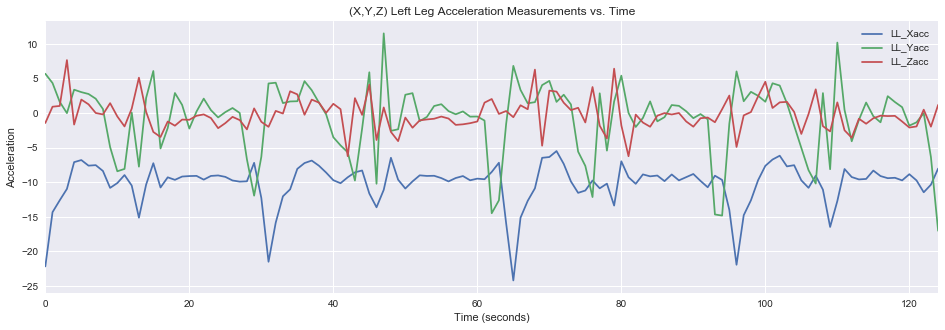

In [90]:
ax = \
df[["LL_Xacc", "LL_Yacc", "LL_Zacc"]].plot(title = "(X,Y,Z) Left Leg Acceleration Measurements vs. Time",
                                           figsize=(16,5));

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");
plt.savefig("./images/Left_Leg_ACC.png")

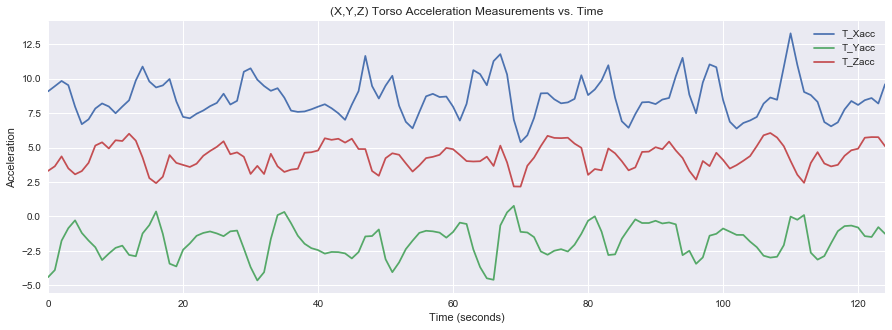

In [36]:
ax = \
df[["T_Xacc", "T_Yacc", "T_Zacc"]].plot(title = "(X,Y,Z) Torso Acceleration Measurements vs. Time",
                                        figsize=(15,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");
plt.savefig("./images/Torso_ACC.png")

We can see from the Left Leg and Torso Acceleration plots that the person must be walking at regular pace. This is evident by the fact that the spacing between the peaks is about constant. If someone where walking at an irregular pace (i.e. slow-fast-slow progression) then we'd expect to see a change of [frequency](https://en.wikipedia.org/wiki/Frequency) (more on frequncy later). 

The acceleration of the device in all three spatial dimensions is periodic, centered around a time invariant mean. 

$$\mu(t)~=~\text{constant}$$

For the curious, the vertical dimension is the X direction and the Z direction points away from the device, parallel to the ground. For more information on the orientation of the dimensions and devices, refer to [Recognizing Daily and Sports Activities](http://yoksis.bilkent.edu.tr/pdf/files/8333.pdf).

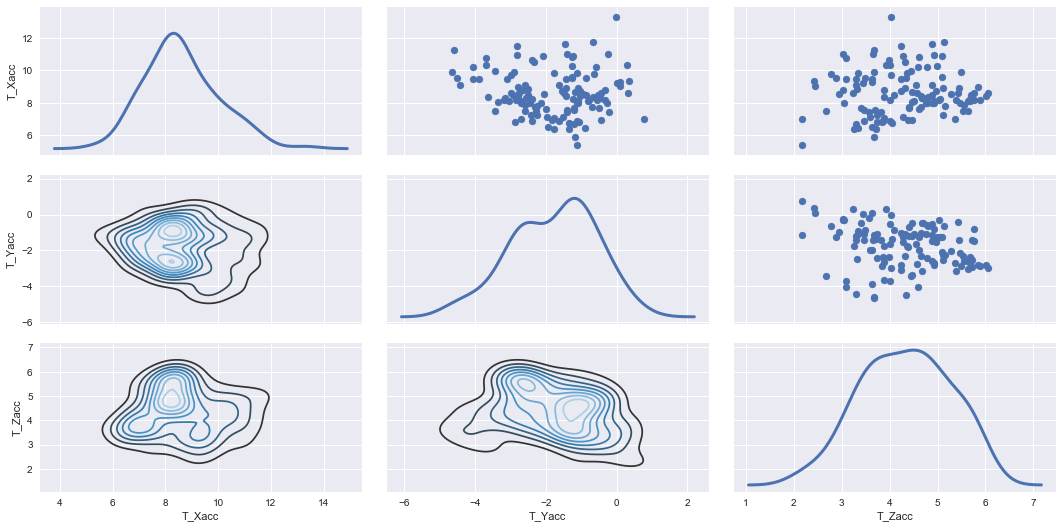

In [9]:
g = sns.PairGrid(df[["T_Xacc", "T_Yacc", "T_Zacc"]],size =2.5, aspect=2.0)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False);
g.savefig("./images/PairGrid.png")

The above pair grid plot show the conditional probabilities: how the X,Y,Z dimensions of the person's acceleration correlate with each other. The diagonal plots show that the signal distributions are approximately gaussian. We can also see that the distributions are centered close to each other in the bottom triangle. The top triangle shows the conditional relationship between the dimensions as a scatter plot. 

These observations are important. Since the signals are approximately normal, we can use this fact to our advantage durint the feature engineering phase (more on that later).

## Feature Engineering

![](http://api.ning.com/files/ewwzspTVVqZ7yGyi4JAL8UaSr7FgAFg4HhNKRKM51v3ofDqR0VcBGJkio9C6je8BKC7DeCrxiZ91hpB0c*C6RlNOd04RPyK2/powertools.png)

We are going to build on the successful research from both papers and adopt their approach to feature engineering. 

We are going to append new features to each segment. The new features are the mean, variance,skewness, and the kurtosis of each row's distribution (since the signals are normal, as we saw earlier, we can calculate their statistical moments) the first ten values of the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
sequence, and the maximum five peaks of the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)
of a segment with the corresponding frequencies.  

We'll normalize each feature to values between [0,1], then flatten each 5 second segment into a single row with 1140 features. Such a large number of features will introduce the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and reduce the performance of most classifiers. So we'll reduce the dimensions by applying [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). 

Each flatten row will then be a single sample (row) in the resulting data matrix that the classifier will ultimately train and test on.

### Steps
    1. Get the 19 additional features for each of the original 45 features. 
    2. Normalize all feature between [0,1]
    3. Reduce dimentions of each segment
    4. Stack the segments to build a data set for each person
    

### 1. Extract 19 Additional features and transform formate of dataset


Let's examine the engineered features in turn. 

####  Mean, Variance, Skewness, and Kurtosis 

We saw that the distribution of each signal are approximately Normal. This means that we can take the first four statistical moments for each 5 second segment. By including the four moments, we are helping our models better learn the characteristic of each unique activity. 

#### Autocorrelation

In some time series analyses, such as in [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), it is desirable to minimize autocorrelation so as to transform the series into a [stationary state](https://en.wikipedia.org/wiki/Stationary_process). We can see in the plot below that after two steps in the lag we hand statistically insignificant autocorrelation in the series that we saw earlier. 


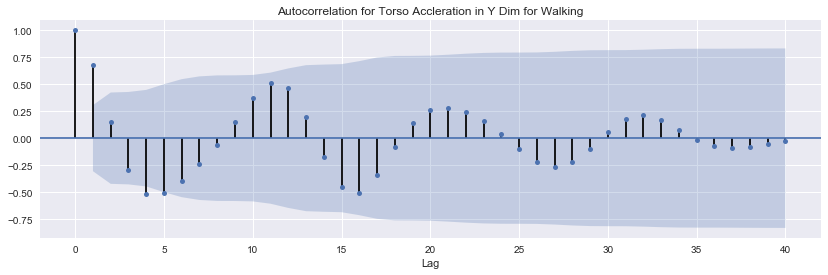

In [8]:
x = [ val[0] for val in df[["T_Yacc"]].values.tolist()]
auto_x = acf(x)

fig, ax = plt.subplots(figsize=(14,4))
title="Autocorrelation for Torso Accleration in Y Dim for Walking"
ax.set_xlabel("Autocorrelation")
ax.set_xlabel("Lag")
plot_acf(auto_x, ax=ax, title=title);
fig.savefig("./images/auto_correlation_walking.png")

For our purposes, we want to extract the first 10 points from the autocorrelation for each sample and treat each of those 10 points as a new feature. Why would we want to do this? The idea is that each physical activity will have a unique sequence of autocorrelation.

Check out the next autocorrelation plot of a different person that is jumping. We can see that this activity has no statistically significant autocorrelation (aside from the perfect autocorrelation at a lag of zero). 

This is the intuition and justification for create new features using the first 10 points from the autocorrelation plot. Ultimately, the validity of this, or any engineered feature, will be determined by the performance of models. 

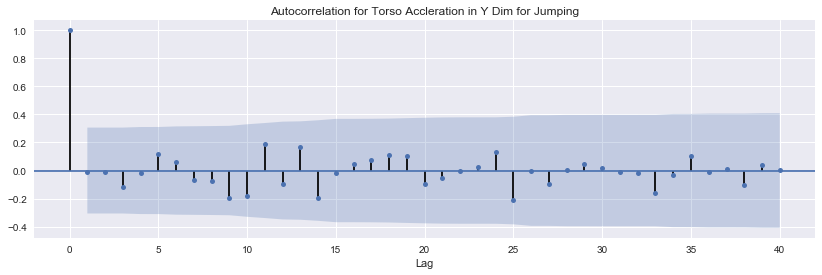

In [9]:
data_home = "/Users/Alexander/Downloads/data/"
user_data = "a18/p3/"

# load data for a different user that is jumping 
file_names = load_segment_names(data_home, user_data)
walk_file = data_home + user_data + file_names[0]
df2 = pd.read_csv(walk_file, names = feat_names)


x2 = [ val[0] for val in df2[["T_Yacc"]].values.tolist()]
auto_x = acf(x2)

fig, ax = plt.subplots(figsize=(14,4))
title="Autocorrelation for Torso Accleration in Y Dim for Jumping"
ax.set_xlabel("Autocorrelation")
ax.set_xlabel("Lag")
plot_acf(auto_x, ax=ax, title=title);
fig.savefig("./images/auto_correlation_jumping.png")

#### Maximum five peaks of the Discrete Fourier Transform

The Fourier Transform function maps a signal back and forth between the time and frequency space. Every signal is the linear combination of sinusoidal functions, sine and cosine. 

**Transform data from time to frequency space:**
$${\displaystyle {\hat {f}}(\xi )=\int _{-\infty }^{\infty }f(x)\ e^{-2\pi ix\xi }\,dx,}$$

**Transform data from frequency to time  space:**
$${\displaystyle f(x)=\int _{-\infty }^{\infty }{\hat {f}}(\xi )\ e^{2\pi i\xi x}\,d\xi ,}$$

The following image shows how a signal can be decomposed into its constitute sinusoidal curves, identifying the frequency of each curve and, finally, representing the original time series as a frequency series. 

![](http://static.nautil.us/1618_f60bb6bb4c96d4df93c51bd69dcc15a0.png)

Below we have plots of the Torso Acceleration in the Y Dim for the Walking series of a single person. The first plot shows what the time series signal looks like and the second plot shows what the corresponding frequency signal looks like. 

For our purposes, we are going to extract the 5 maximum peaks and create features for each of the those values in each of our samples. What are we doing this? Think back to the Fourier Transform image above, the curves with the highest frequency are responsible for the macro-oscillations, while the numerous small frequency curves are responsible for the micro-oscillations. These macro-oscillations are responsbile for the general shape of the curve. Each activity will have a different general shape for its signal. By capturing these influential frequencies, our machine learning models will be better able to distinguish between activities. 

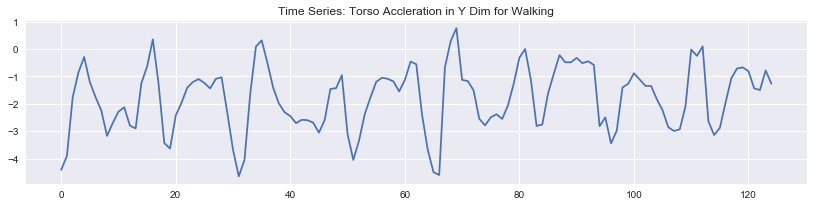

In [10]:
plt.figure(figsize=(14,3))
plt.title("Time Series: Torso Accleration in Y Dim for Walking")
plt.plot(x);
plt.savefig("./images/time_space_walking.png")

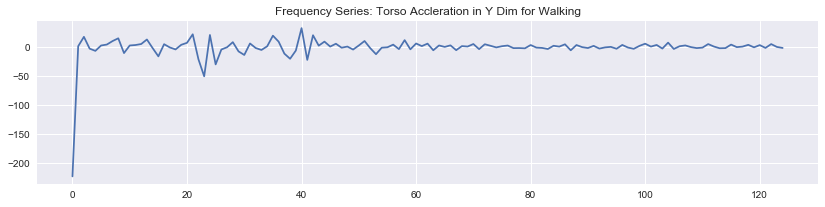

In [11]:
plt.figure(figsize=(14,3))
plt.title("Frequency Series: Torso Accleration in Y Dim for Walking")
plt.plot(rfft(x));
plt.savefig("./images/frequency_space_walking.png")

The following functions will work together to engineer our new features. 

In [67]:
def autocorr(x):
    '''Returns the autocorralation for each of the original 45 features'''
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

def get_segment_features(data):
    '''Returns the extracted features for each of the original 45 features'''
    mean = np.mean(data)
    std = np.std(data)
    kurtosis = stats.kurtosis(data)
    skew = stats.skew(data)
    autocorr_vals = autocorr(data)[0:10].tolist()
    n_max_peaks = 5 # get top n max points to include to features
    n_outlier = 0 # first point is always a large and non-characteristic of the transform
    max_peaks_fft = np.sort(rfft(data))[:-n_outlier][-n_max_peaks:].tolist()
    
    max_peaks_fft.extend([mean, std, skew, kurtosis])
    max_peaks_fft.extend(autocorr_vals)
    
    return max_peaks_fft

def expand_features(df, label):
    '''Append the extracted fetures to each of the original 45 features'''
    data = df.T.values.tolist()
    extracted_features = [get_segment_features(row) for row in data]
    
    n_row = df.T.shape[0] # should be 45 rows in transpose 
    for row_i in xrange(n_row):
        data[row_i].extend(extracted_features[row_i])
        
    data = np.array(data).flatten()
    data = data.tolist()
    data.append(label)
    return data

def get_activity_files_names():
    '''Creates activity file names'''
    activity_files = []
    for num in np.arange(1,20,1):
        if num < 10:
            activity_files.append("a0{}".format(num))
        else:
            activity_files.append("a{}".format(num))
    return activity_files

def get_segment_files_names():
    '''Creates segment file names'''
    segment_files = []
    for num in np.arange(1,61,1):
        if num < 10:
            segment_files.append("s0{}.txt".format(num))
        else:
            segment_files.append("s{}.txt".format(num))
    return segment_files

def transform_data(activity_files, person_files, segment_files):
    '''loads data, extracts features, and transforms data'''
    player_data = defaultdict(list)
    # for activity_i
    for act_i, activity in enumerate(activity_files):
        act_i += 1
        # for person_j
        for per_i, person in enumerate(person_files):
            per_i += 1
            # for segment_k
            for seg_i, segment in enumerate(segment_files): 
                seg_i += 1
                # load segment data
                segment_path = data_home + activity + "/" + person + "/" + segment
                # put data in dataframe
                df = pd.read_csv(segment_path, header=None)
                # feature expand 5 second segment 
                expanded_data = expand_features(df, act_i)
                # each segment is now a row 
                player_data[per_i].append(expanded_data)   
    return player_data

The **get_activity_files_names** function retrives all of the activite tags. There are 19 different activities in total. 

In [24]:
activity_files = get_activity_files_names()
activity_files[0:5]

['a01', 'a02', 'a03', 'a04', 'a05']

The **get_segment_files_names** function retrives all of the segment files. For each user, each activity's total sensor data is saved in 60 files (60 segments). Each segment has 5 seconds of data, each activity has 5 minutes of data recorded. 

In [26]:
segment_files =  get_segment_files_names()
segment_files[0:5]

['s01.txt', 's02.txt', 's03.txt', 's04.txt', 's05.txt']

The following list comprehension creates the 8 user tags. 

In [27]:
person_files = ["p{}".format(num) for num in np.arange(1,9,1)]
person_files

['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

The **transform_data** function performs the transforms that will engineer 19 additional features and flatten out each 5 second segment into a single sample (row). 

In [28]:
start = time()
player_data = transform_data(activity_files, person_files, segment_files)
end = time()
print "Time Elapsed = {:.4} minutes".format((end - start)/60.)

Time Elapsed = 5.116 minutes


In [29]:
# expect to see 1140 rows x ~6000 cols for a single player
np.array(player_data[1]).shape

(1140, 6256)

#### Save data to file

In [9]:
# Save transformed data to pickle file
trans_data_path = "/Users/Alexander/DataBeast/MachineLearning/data/trans_data.pkl"
# pickle.dump(player_data, open(trans_data_path, 'wb'))

#### Load data from file

In [10]:
player_data = pickle.load(open(trans_data_path, 'rb'))

In [11]:
def seperate_data(player_data):
    '''Create the predictor and response data for each player'''
    Y = []
    X = []
    for player_i in player_data.keys():
        x_temp = []
        y_temp = []

        for row in player_data[player_i]:
            y_temp.append(row[-1])
            x_temp.append(row[:-1])

        Y.append(y_temp)
        X.append(x_temp)

    Y = np.array(Y)
    X = np.array(X)
    return X, Y

In [16]:
X, Y = seperate_data(player_data)

In [17]:
print (X.shape)
print (Y.shape)

(8, 1140, 6255)
(8, 1140)


### 2. Normalize all features between [0,1]

In [18]:
scaled_data = np.array([minmax_scale(X[i]) for i in np.arange(0, 8, 1)])


### 3. Reduce dimensions of each segment

In [ ]:
pca = PCA()
# fit pca to the data of a single player for visual purposes
pca.fit(scaled_data[0]);

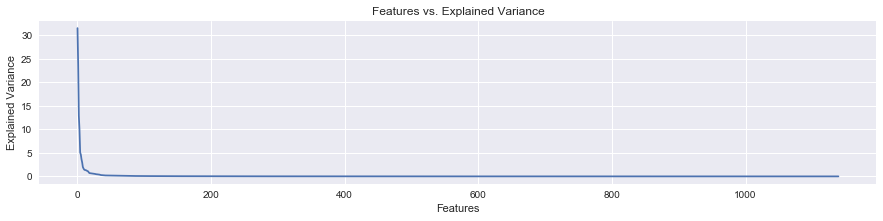

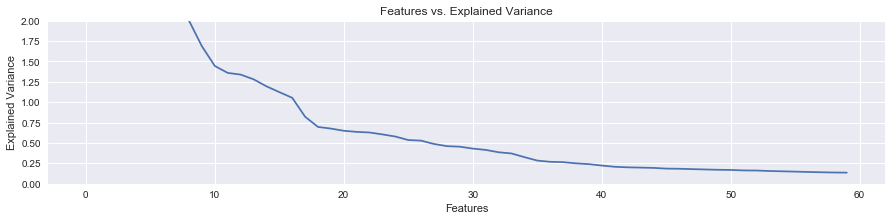

In [21]:
plt.figure(figsize = (15, 3))
plt.title("Features vs. Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Features")
plt.plot(pca.explained_variance_);
plt.savefig('./images/pca_all_features.png')

plt.figure(figsize = (15, 3))
plt.title("Features vs. Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Features")
plt.plot(pca.explained_variance_[:60]);
plt.ylim(0,2);
plt.savefig('./images/pca_60_features.png')


The top plot shows the explained variance of all 1140 features. We can see that explained variance rapidly drops to near zero. 

The bottom plot shows that after the $40^{th}$ dimension the explained variance hardly changes. The goal here is to reduce the number of dimensions and include as much of the explained variance that we can -- it's a balancing act. Both research papers show that they reduced the number of dimensions to 30 and received excellent results. So we'll follow their work and reduce our data set's features to 30 as well. 

If we where to create and follow our own heuristic for determining how many features to keep, we might choose to eliminate all but the minimum number of features that explain 90% of the variance. 

We are going to take the first 30 principal component vectors.

In [19]:
pca = PCA(n_components=30)
reduced_data = np.array([pca.fit_transform(person_i) for person_i in scaled_data])

In [20]:
# 8 people
# 1140 samples
# 30 features 
reduced_data.shape

(8, 1140, 30)

# Modeling and Predictions

![](http://marketplace.thingworx.com/-/media/Images/Neuron/Model%20Building.jpg?hash=2B61C29C1DEFBCFCFA4668A23176014C4A6BCE0B&la=en)

Finally, on to the sexy part! We will explore 2 approaches to predicting the user's activities.  

### Approach 1

We will create train and test sets that contain shuffled samples from each user. So the model will train on data from every user and predict the activities from every user in the test set. 

### Approach 2

We  will include 7 user's data as the training set and use the remaining
user's data as the test set. The goal here is to predict the activities of a user that the model has *never seen before.* 

In each approach we will follow the same model building framework:

1. Split data into train and holdout sets
2. Optimize model hyperparameters
3. Cross Validate model's performance by analyze learning curves

## 1. Split data into train and holdout sets

In [24]:
def attach_user_data(lst):
    '''concatnate user data'''
    data = []
    for row in lst:
        data.extend(row)
    return np.array(data)

In [28]:
X_clean = attach_user_data(reduced_data)
Y_clean = attach_user_data(Y)

In [29]:
print X_clean.shape
print Y_clean.shape

(9120, 30)
(9120,)


In [30]:
X_train, X_holdout, y_train, y_holdout  = train_test_split(X_clean, Y_clean, test_size=.20, random_state=4)

##### Save model ready data to file

In [2]:
# Save transformed data to pickle file
model_ready_data_path = "/Users/Alexander/DataBeast/MachineLearning/data/model_ready_data.pkl"
#pickle.dump([X_train, X_holdout, y_train, y_holdout], open(model_ready_data_path, 'wb'))

##### Load model ready data to file

In [3]:
X_train, X_holdout, y_train, y_holdout = pickle.load(open(model_ready_data_path, 'rb'))

## 2. Optimize model hyperparameters

### Grid Search | Optimized Memory Management 

A naive grid serach implementation will read a copy of the dataset from disk into memory for each unique hyperparameter combination, drastically increasing the time it takes to run a grid search. 

An even more naive grid search implementation will only uses a single core to train models sequentially. Keep in mind fitting one model is a completely independent task from fitting other models. So this task is often referred to as a task that is [**Embarrassingly Parallel**](https://en.wikipedia.org/wiki/Embarrassingly_parallel) in the Data Engineering community. 


The follow grid search implementation uses the ipyparallel package to create a local cluster in order to run multiple simultaneous model fits -- as many as there are cores available. 

This grid search implementation also takes advantage of numpy's memory mapping capabilities. Instead of reading a copy of the dataset from disk each time a model is fitted, we will map a read-only version of the data to memory where every single core can reference it for fitting models. 

The combination of parallelization and memory mapping greatly shortens the grid search process. 

In [15]:
# Data Engineering functions used to greatly speed up model optimization 
def persist_cv_splits(X, y,  n_cv_iter=5, home_path = '/', name='data', suffix="_cv_%03d.pkl", test_size=0.25, random_state=None):
    """Materialize randomized train test splits of a dataset."""

    cv = ShuffleSplit(
                      n_splits=n_cv_iter,
                      test_size=test_size, 
                      random_state=random_state)
    
    cv_split_filenames = []

    for i, (train, test) in enumerate(cv.split(X)):
        
        cv_fold = (X[train], y[train], X[test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(home_path + cv_split_filename)
        
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

def compute_evaluation(cv_split_filename, model, params):
    """Function executed by a worker to evaluate a model on a CV split"""
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib

    X_train, y_train, X_validation, y_validation = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    validation_score = model.score(X_validation, y_validation)
    return validation_score

def grid_search(lb_view, model, cv_split_filenames, param_grid):
    """Launch all grid search evaluation tasks."""
    all_tasks = []
    all_parameters = list(ParameterGrid(param_grid))
    
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, model, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

def progress(tasks):
    return np.mean([task.ready() for task_group in tasks
                                 for task in task_group])

def find_bests(all_parameters, all_tasks, n_top=5):
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
                   
    scores = np.array(mean_scores).T[0]
    sorted_ind = np.argsort(scores)
    top_scores = np.array(mean_scores)[sorted_ind][::-1][:n_top]
    return top_scores

The function **persist_cv_splits** creates cross validation splits of the training data and persist it to memory. 

In [55]:
home_path = "/Users/Alexander/DataBeast/MachineLearning/data/"

digits_split_filenames = persist_cv_splits(X_train, 
                                           y_train, 
                                           n_cv_iter=5,  
                                           home_path = home_path, 
                                           name='biometric', 
                                           random_state=42)

In [26]:
# these are the paths of the 5 cross validation splits that were created for the grid search
digits_split_filenames

['/Users/Alexander/DataBeast/MachineLearning/data/biometric_cv_000.pkl',
 '/Users/Alexander/DataBeast/MachineLearning/data/biometric_cv_001.pkl',
 '/Users/Alexander/DataBeast/MachineLearning/data/biometric_cv_002.pkl',
 '/Users/Alexander/DataBeast/MachineLearning/data/biometric_cv_003.pkl',
 '/Users/Alexander/DataBeast/MachineLearning/data/biometric_cv_004.pkl']

Next we create a local cluster using ipyparallel. In order to communicate with the cluster, we need to create a **Client** which we can use to send commands to the cluster. 

In [27]:
# stop any local cluster that may already be running
!ipcluster stop

2017-04-08 18:52:28.597 [IPClusterStop] CRITICAL | Could not read pid file, cluster is probably not running.


In [28]:
# start up a local cluster of 3 cpus
!ipcluster start -n=3 --daemon

In [29]:
client = Client()

# sanity chck -- we have 3 of the 4 available cpus dedicated to the cluster we have just created
len(client)

Next we want to asynchronously train a model with every possible unique combination of hyperparameters. We can do this by using the **load_balanced_view** method. 

In [31]:
lb_view = client.load_balanced_view()
model = SVC()
svc_params = {'C': np.logspace(-1, 2, 4),
              'gamma': np.logspace(-4, 0, 5),
              'kernel': ["linear", "poly", "rbf"]}

In [32]:
all_parameters, all_tasks = grid_search(lb_view, 
                                        model, 
                                        digits_split_filenames, 
                                        svc_params)

The **find_bests** function allows us to continuously get a read out of what percent of task have been completed. Each task if the fitting and validation of a single combination of hyperparameters. 

The models are being scored on accuracy, which is the floating point values that you see below. The dictionary next to the accuracy score contains the parameters that are responsible for that score. 

In [37]:
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
pprint(find_bests(all_parameters, all_tasks))

Tasks completed: 100.0%
[(0.98859649122807003, {'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}),
 (0.98651315789473681, {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}),
 (0.98541666666666683, {'C': 100.0, 'gamma': 0.01, 'kernel': 'poly'}),
 (0.98541666666666683,
  {'C': 0.10000000000000001, 'gamma': 0.10000000000000001, 'kernel': 'poly'}),
 (0.98475877192982464,
  {'C': 1.0, 'gamma': 0.10000000000000001, 'kernel': 'poly'})]


Now we repeat the same process for a another classifier

In [40]:
lb_view = client.load_balanced_view()
model = RandomForestClassifier()
rfc_params = {'max_depth': [None, 2, 6, 10],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 3, 5]}


In [41]:
all_parameters, all_tasks = grid_search(lb_view, 
                                        model, 
                                        digits_split_filenames, 
                                        rfc_params)

In [43]:
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
pprint(find_bests(all_parameters, all_tasks))

Tasks completed: 100.0%
[(0.96337719298245617,
  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6}),
 (0.96184210526315783,
  {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 6}),
 (0.96162280701754388,
  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4}),
 (0.95964912280701764,
  {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 4}),
 (0.95964912280701742,
  {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2})]


Now that we're done the grid search we can shut down our cluster.


In [44]:
# stop local cluster 
!ipcluster stop

2017-04-08 19:17:53.554 [IPClusterStop] Stopping cluster [pid=2974] with [signal=2]


### 3. Cross Validate model's performance by analyze learning curves

Now that we have optimized the performance of SVM and Random Forest, let's cross validate their performance by checking how well they generalize to the holdout set. 

We'll be using a custom implementation of a learning curve tool.

Before we analyze the optimization results from SVM and Random Forest, let's use Logistic Regression as a baseline. 

In [4]:
lr = LogisticRegression()
learning = cross_validation(lr, 
                            X_train, 
                            y_train, 
                            n_splits=5, 
                            init_chunk_size = 1000, 
                            chunk_spacings = 1000, 
                            average = "macro")

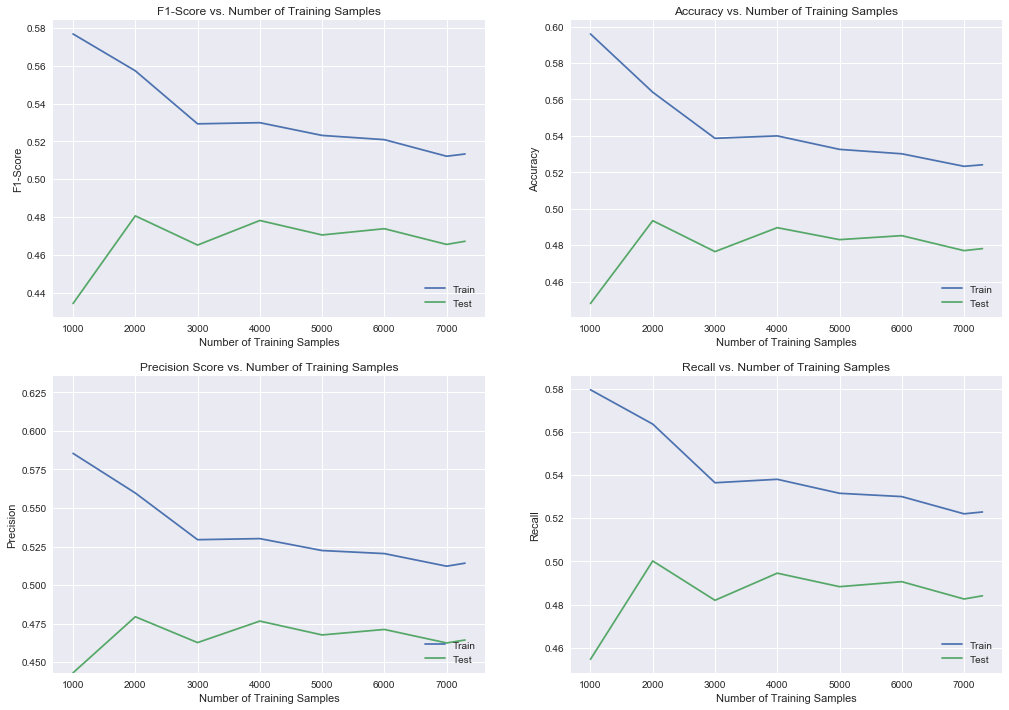

In [5]:
learning.validate_for_holdout_set(X_holdout, y_holdout)
learning.plot_learning_curve(image_name="LR_Learning_Curve", save_image=True)

### Generating the Learning Curves

A learning curve is plotted for each of the four metrics that we'll be using to evaluate the performance of our models: accuracy, precision, recall, and the f1 score. Each point plotted on these graphs is a metric score that was generated by the following cross validation process. 

First the data is split into a train and holdout set. The train set is further split into k folds and each fold is iteratively used as either part of the training set or as the validation set in order to train the model. Once the model is trained, it is used to predict values for the training and holdout sets. The blue curves represent the prediction made on the training set and the green curves represent the predictions made on the test set. 

### Analyzing the Learning Curves

Learning curves contain rich information about our model. 

Let's look at the accuracy learning curves. We can see that the test set score increases by about 5% when we increase the size of the training set from 1000 samples to 2000 samples. As we continue increasing the training set size, we see that the test accuracy doesn't increase. This saturation of the test set accuracy represents the model's **Bias**. The bias indicates that the model is not complex enough to learn from the data, so no matter how many training points it is trained on, it can not increase its performance. This is also known as **Underfitting**. 

The gap between the training and test curves indicates the amount of **variance** in the model's predictions. Ideally, a model will have a very small gap between these two curves indicating that the model can generalize well on unseen data. This is desirable because the alternative are test scores that are worse than training score. This would indicate that the model is learning to only predict data that it has seen before instead of learning generalizable trends and patterns. This is known as **Overfitting**. We can see that Logistic Regression suffers from both Bias and Variance. 

Lastly, we can see that all of the metrics for Logistic Regression never rise above 50%. If we were to randomly guess what class a sample belongs to, we'd be right about 5% of the time (since there are 19 activities). Although LR performs better than random, we want to do much better than 50% accuracy. 


In [6]:
svc = SVC(C= 100.0, gamma=0.01, kernel='rbf')
learning = cross_validation(svc, 
                            X_train, 
                            y_train, 
                            n_splits=5, 
                            init_chunk_size = 1000, 
                            chunk_spacings = 1000, 
                            average = "macro")

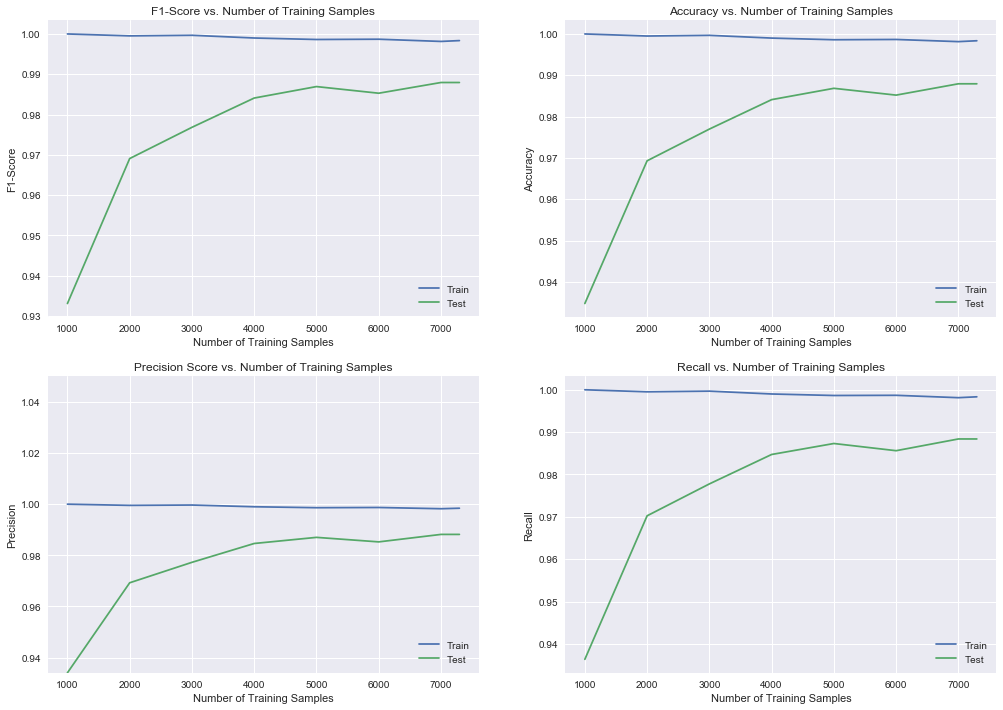

In [7]:
learning.validate_for_holdout_set(X_holdout, y_holdout)
learning.plot_learning_curve("SVM_Learning_Curve", save_image=True)

The Supportive Vector Machine model performed substantially better than Logistic Regression. Take a look at the accuracy curve. It shows that the model was able to do a near perfect job at predicting the activity classification for the training set. 

More importantly, the model is classifying activities from the test set at near 99% accuracy. The test curve shows that SVM's performance increases as it is trained on larger datasets. The gap between the train and test curves may appear significant, but keep in mind that the difference between these two curves is about 0.01% -- a very small difference. We can conclude from these learning curves that SVM suffers from very small amounts of bias and variance.  This is the type of performance that we desire in models that will be pushed into [production](http://stackoverflow.com/questions/490289/what-exactly-defines-production). 

---

### Precision | Recall

So far we have been focusing on the accuracy metric, but what about precision and recall? 

**Precision** tells us about what percentage of classifications predicted to be positive are actually positive. For simplicity, let's say we are dealing with a binary classification problem in which 100 samples are predicted to belong to the positive class. 90 out of 100 positive predictions actually belong to the positive class, in which case we label those predicitons as **True Positives (TP)**. On the other hand, 10 out of 100 positives predictions don't actually belong to the positive class, they were negative samples incorrectly predicted to be positive, in which case we label those predictions as **False Positives (FP)**. 

**Recall** tells us how well the model can identify points that belong to the positive class. This may sound a lot like precision but it's not. Recall compares TP with **False Negatives (FN)**, where as precision compares TP with FP. The distinction here is that for every sample that is falsely predicted to belong to negative class, that is one less sample that the model can correctly identify as belonging to the positive class. 

**Recall is a measure of the failure in distinguishing between positive and negative classifications. **

**Precision is a measure of the failure to correctly predict positive classifications. **

$$\textbf{Precision} = \frac{TP}{TP + FP}$$

$$\textbf{Recall} = \frac{TP}{TP + FN}$$

Lastly, the $f_{1} score$ is a weighted average of precision and recall. The  $f_{1} score$  is used to get a measure of both types of failures. 

---

Bring it back to our case study, take a look at the precision curve for SVM. It is telling us that 99 out of 100 samples that are predicted to belong to the positive class do actually belong to the positive class. Now, because our data set has 19 classes,  and not 2, the labels 'positive' and 'negative' class lose meaning. When more than 2 classifications are present, we can reinterpret the test set precision learning curve:  99 out of 100 classifications that are predicted to belong a specific class do actually belong to that class. 

In [64]:
rfc = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=6)
learning = cross_validation(rfc, 
                            X_train, 
                            y_train, 
                            n_splits=5, 
                            init_chunk_size = 1000, 
                            chunk_spacings = 1000, 
                            average = "macro")

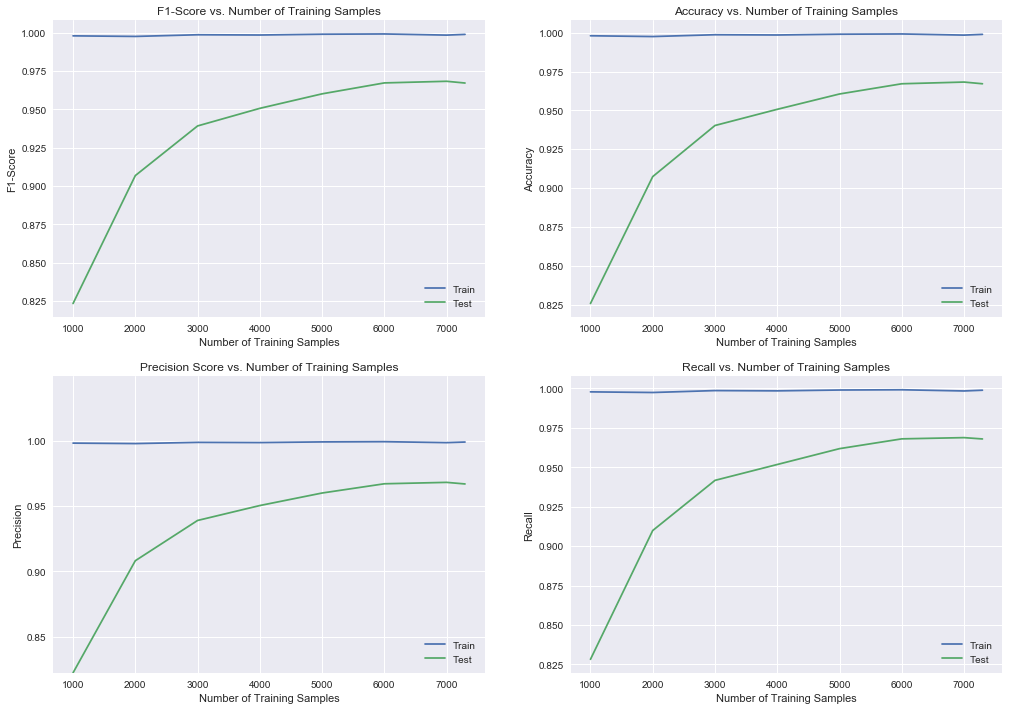

In [65]:
learning.validate_for_holdout_set(X_holdout, y_holdout)
learning.plot_learning_curve()

We can see here that Random Forest preform almost as well as SVM. However there is slightly more variance in the predictions. 

### Modeling Approach 2

We will create a training set comprised of 7 randomly chosen users and a test set comprised of the remaining user. This is the more interesting case. We want to be able to train a model to predict which activities a previously unseen user is engaged in, not just for users that it has seen before.

In [21]:
# comprised of 7 users
X_train = reduced_data[1:]
y_train =  Y[1:]

# comprised of the remaining user
X_test = reduced_data[0]
y_test = Y[0]

In [22]:
print (X_train.shape)
print (y_train.shape)

(7, 1140, 30)
(7, 1140)


In [25]:
X_train_clean = attach_user_data(X_train)
Y_train_clean = attach_user_data(y_train)

In [26]:
print (X_train_clean.shape)
print (Y_train_clean.shape)

(7980, 30)
(7980,)


### Optimize Model Hyperparameters

In [20]:
home_path = "/Users/Alexander/DataBeast/MachineLearning/data/"

split_filenames = persist_cv_splits(X_train_clean, 
                                    Y_train_clean, 
                                    n_cv_iter=5,  
                                    home_path = home_path, 
                                    name='biometric', 
                                    random_state=42)

In [21]:
# stop any local cluster that may already be running
!ipcluster stop

2017-04-15 15:22:15.423 [IPClusterStop] Stopping cluster [pid=1199] with [signal=<Signals.SIGINT: 2>]


In [22]:
# start up a local cluster of 3 cpus
!ipcluster start -n=3 --daemon

In [25]:
client = Client()

# sanity chck -- we have 3 of the 4 available cpus dedicated to the cluster we have just created
len(client)

3

In [26]:
lb_view = client.load_balanced_view()
model = SVC()
svc_params = {'C': np.logspace(-1, 2, 4),
              'gamma': np.logspace(-4, 0, 5),
              'kernel': ["linear", "poly", "rbf"]}

In [27]:
all_parameters, all_tasks = grid_search(lb_view, 
                                        model, 
                                        split_filenames, 
                                        svc_params)

In [52]:
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
pprint(find_bests(all_parameters, all_tasks))

Tasks completed: 92.66666666666666%
array([[0.99137844611528825, {'gamma': 0.01, 'C': 100.0, 'kernel': 'rbf'}],
       [0.98927318295739342, {'gamma': 0.01, 'C': 10.0, 'kernel': 'rbf'}],
       [0.98877192982456141, {'gamma': 0.01, 'C': 100.0, 'kernel': 'poly'}],
       [0.98877192982456141,
        {'gamma': 0.10000000000000001, 'C': 0.10000000000000001, 'kernel': 'poly'}],
       [0.98796992481202994,
        {'gamma': 0.10000000000000001, 'C': 1.0, 'kernel': 'poly'}]], dtype=object)


### Modeling

In [28]:
svc = SVC(C= 100.0, gamma=0.01, kernel='rbf')
learning = cross_validation(svc, 
                            X_train_clean, 
                            Y_train_clean, 
                            n_splits=5, 
                            init_chunk_size = 1000, 
                            chunk_spacings = 1000, 
                            average = "macro")

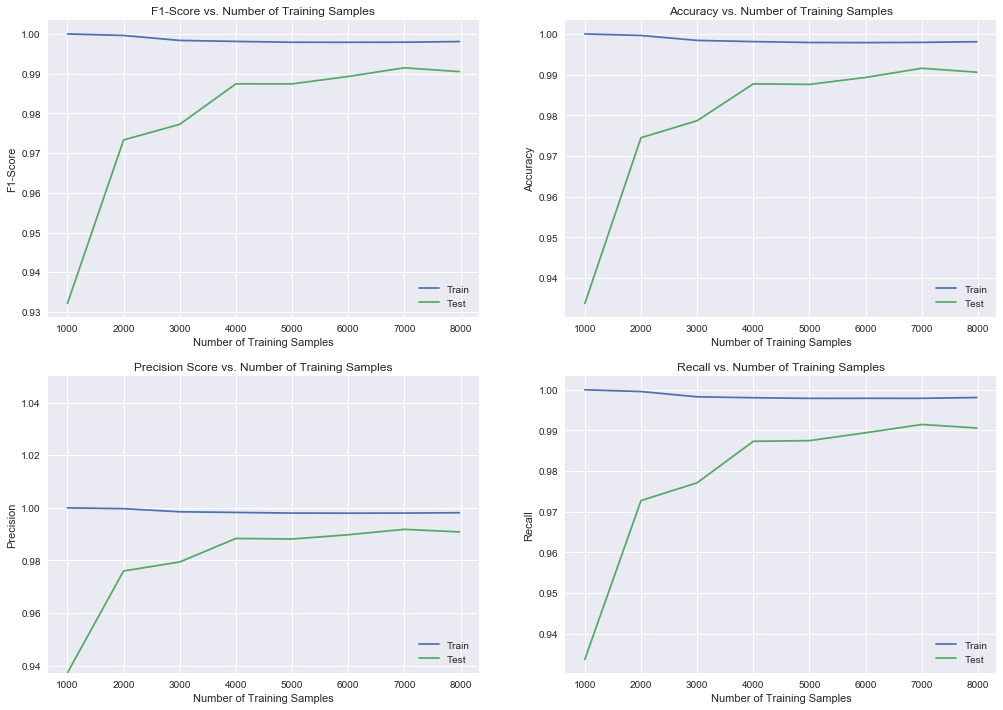

In [76]:
learning.train_for_learning_curve()
learning.plot_learning_curve()

These learning curves are the result of cross validating the model on the training set alone. Unsurprisingly, the model performs very well. This is because we are using the same data set that was used to optimize the hyperparameters. These plots are provided to contrast them with the test set learning curves. 

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


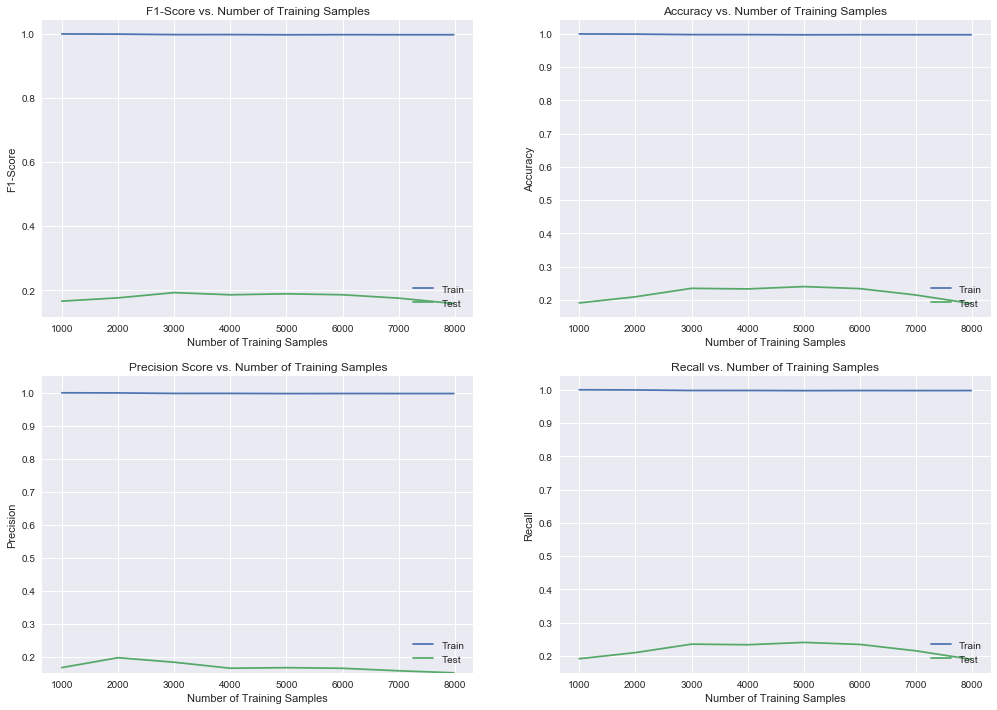

In [29]:
learning.validate_for_holdout_set(X_test, y_test)
learning.plot_learning_curve("SVM_2nd_Learning_Curve", save_image=True)

Whoa! What happened? 

Recall that the training set contains 7 users and the test set contains the 8th user. The learning curves show a tremendous amount of overfitting. The training curves in blue represent the 7 users in the training set. The model can predict activities from users that it has seen already. However the green curves tell us that the model is unable to generalize to new users. 

These results are likely attributed to the feature engineering approach that we took. People are unique in how they walk, jump, walk up and down stairs, and so on. It is reasonable to conclude that we have succeeded in capturing the  characteristic body movements from specific individuals but have fallen short of capturing a general understanding how how these activities are performed in groups of people. 

Depending on our purpose, we can arrive at the conclusion that we have succeeded or fallen short of our goals. If our goal is to build and dedicate a model for each individual, then we can conclude that this work is a smashing success!

On the other hand, if our goal is to build a model that learns what the walk signal or the jump signal looks like from any user, then we would have to admit that we have fallen short. 

# Conclusion 

We have seen how an understanding of time series data and signal processing can lead to engineering features and building machine learning models that predict which activity users are engaged in with 99% accuracy. 

Our approach proved successful in building a model that can predict activities from users that appear in both the training and test set. The model was able to learn which signals correspond to activities like walking or jumping for specific users. However, when users are limited to appearing in either the training or test set, we saw that the model is unable to acquire a generalized understanding of which signals correspond to specific activities, independent of the user.

-----

# About the Author

Alexander Barriga has a M.S. in Data Science from GalvanizeU (University of New Haven) and a B.A. in Physics from UC Berkeley. He currently works as a Data Science instructor at General Assembly in San Francisco. 

